In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch, time
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn, optim


#Set location of the torch tensor
use_cuda = torch.cuda.is_available()
print('Availability of GPU:',use_cuda)
if use_cuda: torch_ft = torch.cuda.FloatTensor
else: torch_ft = torch.FloatTensor

Availability of CUDA: False


In [ ]:
#download the data
!wget http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz
!gunzip atlas-higgs-challenge-2014-v2.csv.gz

In [3]:
#Read the data (the input file contains ~820k different events)
df = pd.read_csv('atlas-higgs-challenge-2014-v2.csv')

In [4]:
#remove unnecessary variables
df = df.drop('EventId',axis=1).drop('Weight',axis=1).drop('KaggleSet',axis=1).drop('KaggleWeight',axis=1)

Define training, validation and test sets, at the beginning use small dataset for model selection

In [46]:
training_df = df[:500000]
valid_df = df[500000:650000]
test_df = df[650000:]

#training_df = df[:5000]
#valid_df = df[5000:6500]



## Creating a DataLoader

In exercise 1 we used [fastai.tabular](https://docs.fast.ai/tabular.data.html) module:
```python
from fastai.tabular import TabularDataBunch
data = TabularDataBunch.from_df(path, df:DataFrame, dep_var:str, valid_idx:Collection[int], 
                         procs:Optional[Collection[TabularProc]]=None, cat_names:OptStrList=None, 
                         cont_names:OptStrList=None, classes:Collection[T_co]=None, test_df=None, 
                         bs:int=64, val_bs:int=None, num_workers:int=4, 
                         dl_tfms:Optional[Collection[Callable]]=None, device:device=None, 
                         collate_fn:Callable='data_collate', no_check:bool=False) → DataBunch
```
Today we will write our own function to generate mini-batches. It is done in two steps:
- creating a DataSet
- creating a DataLoader

In [57]:
dep_var = 'Label'
batch_size = len(training_df)

#convert pandas dataframe to torch tensor
train_target = torch_ft(training_df[dep_var].replace({'s':1,'b':0}).values.astype(np.float32))
train_dataset = torch_ft(training_df.drop(dep_var, axis = 1).values.astype(np.float32)) 

#use torch tensor as input to mini-batch generator
train_dataset = TensorDataset(train_dataset, train_target) 
train_generator = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

#repeat for the validation set, here use full batch for evaluation
valid_target = torch_ft(valid_df[dep_var].replace({'s':1,'b':0}).values.astype(np.float32))
valid_dataset = torch_ft(valid_df.drop(dep_var, axis = 1).values.astype(np.float32)) 

valid_dataset = TensorDataset(valid_dataset, valid_target) 
valid_generator = DataLoader(dataset = valid_dataset, batch_size = len(valid_df), shuffle = True)



## Learner (train function)

In ex. 1 we used `Learner()` from [basic_train](https://docs.fast.ai/basic_train.html#Learner) library
```python 
learn = Learner(data, net, loss_func = nn.CrossEntropyLoss())
```
Here we will write a Learner with the `fit` function

In [64]:
class Learner():
    def __init__(self, data_loader, model, optimizer, criterion, valid_loader = None):
        
        self.data_loader = data_loader
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.valid_loader = valid_loader
        if torch.cuda.is_available() and not next(model.parameters()).is_cuda:
            print('copy the model to GPU')
            model.to(torch.device("cuda"))
            

    def fit(self, epochs = 1, cache={'loss':[]}):
        
        tic = time.time()
        
        # Iteration over the epochs
        for epoch in range(epochs):
        
            #Loop over the mini-batches
            for i, (batch_input, batch_target) in enumerate(self.data_loader):

                #evaluate the model, and compute the gradients
                batch_output = self.model(batch_input)
                loss=self.criterion(batch_output, batch_target)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            cache['loss'].append(loss.item())

            #evaluate validation loss:
            if self.valid_loader:
                with torch.no_grad():
                    valid_input, valid_target = next(iter(self.valid_loader))
                    valid_output = self.model(valid_input)
                    vloss = criterion(valid_output, valid_target)
                    cache['val_loss'].append(vloss.item())

                printProgressBar(epoch, epochs, [loss.item(),vloss.item()])
            else: printProgressBar(epoch, epochs, [loss.item()])
        toc = time.time()
        print('total time: %2.2f sec' %(toc-tic))
        return cache


def printProgressBar (iteration, total, losses = [], decimals = 1, length = 50):
    total = total - 1 #since usually we start from 0 till n-1
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = '#' * filledLength + '-' * (length - filledLength)
    if len(losses)==1:
        print('\rprogress |%s| %s%% loss - %s' % (bar, percent, str(losses[0])), end = '\r')
    else:
        print('\rprogress |%s| %s%% loss - %2.5f | validation - %2.5f' % 
              (bar, percent, float(losses[0]), float(losses[1])), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()
        
def CreateCash(model):
    cache={}
    for c in (['loss']+['val_loss']+[*model.state_dict().keys()]):
        cache[c]=[]
    return cache

## Building a model

Let's construct a simple NN, for the propose we will use 4-Layer NN with H = [100,50,10]
![4-Layer NN](images/4L_NN.png)

In [65]:
input_dim = 30                # dimentions of the input layer
H = [100, 50, 10]             # dimentions of the hidden layers

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Linear(input_dim,H[0])
        self.layer2 = nn.Linear(H[0],H[1])
        self.layer3 = nn.Linear(H[1],H[2])
        self.layer4 = nn.Linear(H[2],1)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        #note: we dont use categories, but we need to set it up in the model
        out  = self.layer1(x)
        out  = self.activation(out)
        out  = self.layer2(out)
        out  = self.activation(out)
        out  = self.layer3(out)
        out  = self.activation(out)
        out  = self.layer4(out)
        out  = self.sigmoid(out)
        
        return out.view(-1)

# Training the model

to run the train function we need to define the loss and optimizer

In [66]:
net = Net()
cache = CreateCash(net)
criterion = getattr(nn.functional, 'binary_cross_entropy') #advanced user would like to try binary_cross_entropy_with_logits
optimizer = optim.SGD(net.parameters(), lr = 1e-3)
learn = Learner(train_generator, net, optimizer, criterion, valid_loader = valid_generator)  

All set!! we can start to train our model! Instead of running:
```python 
learn.fit(epochs = 2, lr = 5e-3)
```
we will run our `Learner.fit`

In [ ]:
cache = learn.fit(10, cache)
plt.plot(cache['loss'],label='training loss')
plt.plot(cache['val_loss'],label='validation loss')
plt.legend(); plt.show() 

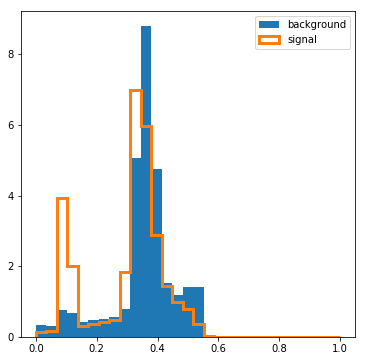

In [56]:
with torch.no_grad():
    inputs, y = next(iter(valid_generator))
    preds = net(inputs)
    
preds = preds.data.numpy()
preds_sig = preds[y.numpy()==0]
preds_bkg = preds[y.numpy()==1]

bins = np.linspace(0,1,30)

fig,ax = plt.subplots(figsize=(6,6))

ax.hist(preds_bkg,bins=bins,density=True,label='background')
ax.hist(preds_sig,bins=bins,density=True,histtype='step',linewidth=3,label='signal')
plt.legend()
plt.show()

In [ ]:
X[1].shape

In [ ]:
learn.lr_find()

In [ ]:
!nvidia-smi